In [16]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)


import seaborn as sns
plt.style.use("fivethirtyeight")
sns.set_style('whitegrid')
%matplotlib inline
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)




No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


### loading train and test datasets

In [2]:
train = web.DataReader('MSFT', data_source='yahoo', start='2016-11-07', end='2021-11-05')

In [3]:
train = train.iloc[:,:5]
train

,High,Low,Open,Close,Volume
Date,,,,,
2016-11-07,60.520000,59.779999,59.779999,60.419998,31664800.0
2016-11-08,60.779999,60.150002,60.549999,60.470001,22935400.0
2016-11-09,60.590000,59.200001,60.000000,60.169998,49632500.0
2016-11-10,60.490002,57.630001,60.480000,58.700001,57822400.0
2016-11-11,59.119999,58.009998,58.230000,59.020000,38767800.0
...,...,...,...,...,...
2021-11-01,331.489990,326.369995,331.359985,329.369995,27073200.0
2021-11-02,333.450012,330.000000,330.309998,333.130005,26487100.0
2021-11-03,334.899994,330.649994,333.899994,334.000000,21500100.0


### Generating test dates 

In [4]:
#specify the start and the end of the test period
start='2021-11-08'
end='2021-11-19'
#date for test period
test_date = pd.date_range(start, end, freq='B')

In [5]:
test_date

DatetimeIndex(['2021-11-08', '2021-11-09', '2021-11-10', '2021-11-11',
               '2021-11-12', '2021-11-15', '2021-11-16', '2021-11-17',
               '2021-11-18', '2021-11-19'],
              dtype='datetime64[ns]', freq='B')

### Cutting windows on the train data

In [6]:
#function to prepare data for LSTM and GRU
def prepare_data(data_lstm,lookback ,future):
    # generate the input and output sequences
    data_lstm = np.array(data_lstm)
    data_lstm = data_lstm.reshape(-1,1)
    X_ = []
    Y_ = []

    for i in range(lookback, len(data_lstm) - future + 1):
        X_.append(data_lstm[i - lookback: i])
        Y_.append(data_lstm[i: i + future])

    X_ = np.array(X_)
    Y_ = np.array(Y_)
    return(X_,Y_)

### LSTM model

In [7]:
#LSTM model
def model_lstm(dataframe,test_date, lookback, future, epochs = 100):
    cols = dataframe.columns
    #a zero filled dataframe to capture the predicted values
    d = pd.DataFrame(0, index=np.arange(len(test_date)), columns=cols)
    #assigning test dates to the zero filled dataframe
    d.index = test_date
    
    #calling each column at a time
    for col in cols:
        data = dataframe[col]
        #standardization
        m = data.mean()
        s = data.std()
        data = (data - m)/s
        #calling the data preparation function
        X, Y = prepare_data(data,30 ,len(test_date))

        #callbacks to monitor overfitting
        my_callbacks = [
        tensorflow.keras.callbacks.EarlyStopping(patience=5),
        ]
        #initializing the weights
        np.random.seed(1)
        tensorflow.random.set_seed(1)
        #model
        model = Sequential()
        model.add(LSTM(lookback, activation='relu', return_sequences=True))
        model.add(LSTM(lookback, activation='relu'))
        model.add(Dense(future))
        model.compile(optimizer='Adam', loss='mse', metrics = 'mse')
        #fitting
        history = model.fit(X, Y, epochs=epochs , validation_split=0.2, verbose=0, shuffle=False, callbacks = my_callbacks)
        #separating the last instance of the train data to make future prediction
        xt = X[-1].reshape(1,-1,1)
        #future prediction
        yp = model.predict(xt)
        #retransforming data to original
        yp = yp *s + m
        #appending the predictions to the zero filled column
        d[col] = yp.flatten()
        
    return d

In [8]:
lstm_df = model_lstm(train,test_date, 100, len(test_date), epochs = 10)

### Predicted prices and volume using LSTM

In [9]:
lstm_df

,High,Low,Open,Close,Volume
2021-11-08,453.807465,113.907402,369.046783,347.970062,23382072.0
2021-11-09,389.259888,939.976318,340.658203,335.299133,23722150.0
2021-11-10,455.801453,998.678345,372.960266,323.951965,24423778.0
2021-11-11,394.763184,838.852905,326.093506,319.191589,24874018.0
2021-11-12,548.066528,747.543945,368.222992,359.939087,24984534.0
2021-11-15,500.526520,1143.787598,378.843628,305.632050,25812592.0
2021-11-16,444.349457,1381.851440,357.235046,309.840332,25439978.0
2021-11-17,519.050049,1067.114380,357.498657,330.885315,25562022.0
2021-11-18,434.765381,1450.987427,365.012238,319.315521,25718966.0
2021-11-19,479.481110,1298.544678,382.027466,349.178772,25643428.0


### GRU model

In [10]:
#GRU model
def model_gru(dataframe,test_date, lookback, future, epochs = 100):
    cols = dataframe.columns
    #a zero filled dataframe to capture the predicted values
    d = pd.DataFrame(0, index=np.arange(len(test_date)), columns=cols)
    #assigning test dates to the zero filled dataframe
    d.index = test_date
    
    #calling each column at a time
    for col in cols:
        data = dataframe[col]
        #standardization
        m = data.mean()
        s = data.std()
        data = (data - m)/s
        #calling the data preparation function
        X, Y = prepare_data(data,30 ,len(test_date))

        #callbacks to monitor overfitting
        my_callbacks = [
        tensorflow.keras.callbacks.EarlyStopping(patience=5),
        ]
        #initializing the weights
        np.random.seed(1)
        tensorflow.random.set_seed(1)
        #model
        model = Sequential()
        model.add(GRU(lookback, activation='relu', return_sequences=True))
        model.add(GRU(lookback, activation='relu'))
        model.add(Dense(future))
        model.compile(optimizer='Adam', loss='mse', metrics = 'mse')
        #fitting
        history = model.fit(X, Y, epochs=epochs , validation_split=0.2, verbose=0, shuffle=False, callbacks = my_callbacks)
        #separating the last instance of the train data to make future prediction
        xt = X[-1].reshape(1,-1,1)
        #future prediction
        yp = model.predict(xt)
        #retransforming data to original
        yp = yp *s + m
        #appending the predictions to the zero filled column
        d[col] = yp.flatten()
        
    return d

In [11]:
gru_df = model_gru(train,test_date, 100, len(test_date), epochs = 10)

### Predicted prices and volume using LSTM

In [12]:
gru_df

,High,Low,Open,Close,Volume
2021-11-08,304.583191,293.498779,306.677704,282.626038,20585154.0
2021-11-09,286.629791,296.708984,304.934143,277.761719,21637188.0
2021-11-10,297.583710,296.267151,307.456726,281.845703,22462628.0
2021-11-11,286.306000,294.387878,305.056854,274.119537,22723510.0
2021-11-12,284.269287,294.935120,300.597168,278.689575,23061100.0
2021-11-15,289.358032,291.721252,300.185608,274.303955,23852982.0
2021-11-16,292.693787,294.014221,303.090302,277.942413,24242236.0
2021-11-17,296.240997,298.834900,308.008118,283.164795,23938130.0
2021-11-18,292.643494,296.763611,305.462982,283.082245,23905736.0
2021-11-19,297.274353,299.499481,309.580780,283.718201,23808290.0


### Visualizing the forecasted results of both the models

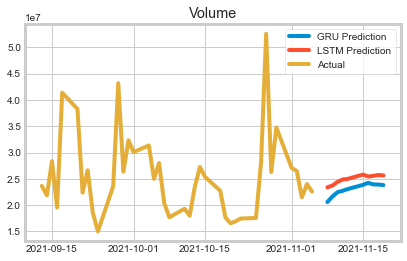

In [15]:
plt.plot(gru_df['Volume'], label = 'GRU Prediction')
plt.plot(lstm_df['Volume'], label = 'LSTM Prediction')
plt.plot(train['Volume'][-40:], label = 'Actual')
plt.title('Volume')
plt.legend()

### Due to limitations of my laptop i was not able to train for more than 10 epochs without the kernel crashing. 